# Asbtractive Text Summarization:

## News Summary Data from inshorts

In [5]:
#!pip install chart_studio

In [6]:
#!gdown https://drive.google.com/uc?id=1apcfE6-zkIQfXJbJNx2cLQVzpfSXOH7m

In [7]:
#!gdown https://drive.google.com/uc?id=1gyjAv5UiY5KeJAEsjhm6g5wUZkaRVFbl

In [8]:
#!gdown https://drive.google.com/uc?id=1QGZ8_P0TwqgFNE8SvxnMoIUNIiI-z6ci

In [3]:
import gc
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from nltk.tokenize import word_tokenize
import re
import collections
import pickle
import numpy as np
from gensim.models.keyedvectors import KeyedVectors
from gensim.test.utils import get_tmpfile
from gensim.scripts.glove2word2vec import glove2word2vec


import os
import chart_studio.plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction import stop_words
import re
import string
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, sys, tarfile
from sklearn.model_selection import train_test_split

from IPython.display import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Input
from tensorflow.keras.layers import Embedding, LSTM, Dense, TimeDistributed, Layer
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.



In [4]:
pd.set_option('display.max_info_columns',1000)
pd.set_option('display.max_colwidth',5000)

In [5]:
news1 = pd.read_csv('/content/news_summary.csv', encoding='latin-1', usecols=['headlines', 'text'])
news2 = pd.read_csv('/content/news_summary_more.csv', encoding='latin-1')
news_summary = pd.concat([news1, news2], axis=0).reset_index(drop=True)
news_summary.head()       

,headlines,text
0,Daman & Diu revokes mandatory Rakshabandhan in offices order,The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The administration was forced to withdraw the decision within 24 hours of issuing the circular after it received flak from employees and was slammed on social media.
1,Malaika slams user who trolled her for 'divorcing rich man',"Malaika Arora slammed an Instagram user who trolled her for ""divorcing a rich man"" and ""having fun with the alimony"". ""Her life now is all about wearing short clothes, going to gym or salon, enjoying vacation[s],"" the user commented. Malaika responded, ""You certainly got to get your damn facts right before spewing sh*t on me...when you know nothing about me."""
2,'Virgin' now corrected to 'Unmarried' in IGIMS' form,"The Indira Gandhi Institute of Medical Sciences (IGIMS) in Patna on Thursday made corrections in its Marital Declaration Form by changing 'Virgin' option to 'Unmarried'. Earlier, Bihar Health Minister defined virgin as being an unmarried woman and did not consider the term objectionable. The institute, however, faced strong backlash for asking new recruits to declare their virginity in the form."
3,Aaj aapne pakad liya: LeT man Dujana before being killed,"Lashkar-e-Taiba's Kashmir commander Abu Dujana, who was killed by security forces, said ""Kabhi hum aage, kabhi aap, aaj aapne pakad liya, mubarak ho aapko (Today you caught me. Congratulations)"" after being caught. He added that he won't surrender, and whatever is in his fate will happen to him. ""Hum nikley they shaheed hone (had left home for martyrdom),"" he added."
4,Hotel staff to get training to spot signs of sex trafficking,"Hotels in Maharashtra will train their staff to spot signs of sex trafficking, including frequent requests for bed linen changes and 'Do not disturb' signs left on room doors for days. A mobile phone app called Rescue Me, which will allow staff to alert police of suspicious behaviour, will be developed. The initiative has been backed by the Maharashtra government."


In [6]:
news_summary.shape

(102915, 2)

## Text Preprocessing:

In [7]:
def preprocess(text):
    """Preprocess the given text."""
    
    # Encode to ascii
    #text = ''.join(c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn')
    
    # To lowercase
    text = text.lower()

    text = re.sub("(\\t)", ' ', text)  #remove escape charecters
    text = re.sub("(\\r)", ' ', text)
    text = re.sub("(\\n)", ' ', text)
    text = re.sub("(__+)", ' ', text)   #remove _ if it occors more than one time consecutively
    text = re.sub("(--+)", ' ', text)   #remove - if it occors more than one time consecutively
    text = re.sub("(~~+)", ' ', text)   #remove ~ if it occors more than one time consecutively
    text = re.sub("(\+\++)", ' ', text)   #remove + if it occors more than one time consecutively
    text = re.sub("(\.\.+)", ' ', text)   #remove . if it occors more than one time consecutively
    text = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', text) #remove <>()|&©ø"',;?~*!
    text = re.sub("(mailto:)", ' ', text)  #remove mailto:
    text = re.sub(r"(\\x9\d)", ' ', text)  #remove \x9* in text
    text = re.sub("([iI][nN][cC]\d+)", 'INC_NUM', text)  #replace INC nums to INC_NUM
    text = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', text)  #replace CM# and CHG# to CM_NUM
    text = re.sub("(\.\s+)", ' ', text)  #remove full stop at end of words(not between)
    text = re.sub("(\-\s+)", ' ', text)  #remove - at end of words(not between)
    text = re.sub("(\:\s+)", ' ', text)  #remove : at end of words(not between)
    text = re.sub("(\s+.\s+)", ' ', text)  #remove any single charecters hanging between 2 spaces

    #Replace any url as such https://abc.xyz.net/browse/sdf-5327 ====> abc.xyz.net
    try:
        url = re.search(r'(https*:\/*)([^\/\s]+)(.[^\s]+)', text)
        repl_url = url.group(2)
        text = re.sub(r'(https*:\/*)([^\/\s]+)(.[^\s]+)',repl_url, text)
    except:
        pass #there might be emails with no url in them

    text = re.sub("(\s+)",' ',text) #remove multiple spaces
    text = re.sub("(\s+.\s+)", ' ', text) #remove any single charecters hanging between 2 spaces
    return text


In [8]:
news_summary['headlines'] = news_summary['headlines'].apply(preprocess)
news_summary['text'] = news_summary['text'].apply(preprocess)
news_summary.head(1)

,headlines,text
0,daman diu revokes mandatory rakshabandhan in offices order,the administration of union territory daman and diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of rakshabandhan on august the administration was forced to withdraw the decision within 24 hours of issuing the circular after it received flak from employees and was slammed on social media.


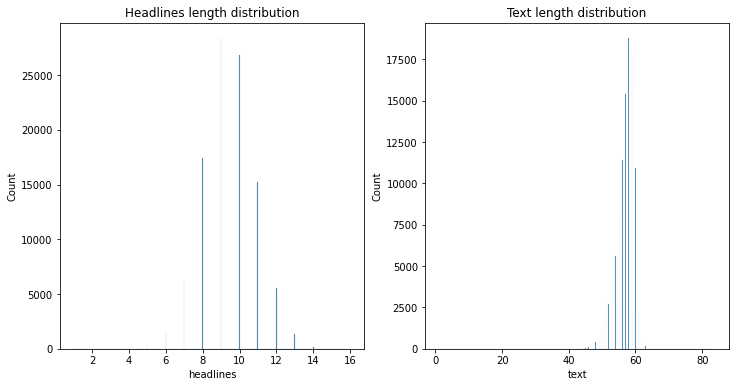

In [9]:
text_len = news_summary['text'].str.split().apply(len)
headline_len = news_summary['headlines'].str.split().apply(len)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(headline_len)
plt.title('Headlines length distribution')

plt.subplot(1, 2, 2)
sns.histplot(text_len)
plt.title('Text length distribution')

plt.show()


In [10]:
text_len.mean(),headline_len.mean()

(56.92494777243356, 9.438177136471845)

In [11]:
print(f"Headlines having length in range [0, 15]: {len(headline_len[headline_len <= 15])/len(headline_len)}")

# Check how much % of text have 0-62 words
print(f"Text having length in range [0, 62]: {len(text_len[text_len <= 63])/len(text_len)}")


Headlines having length in range [0, 15]: 0.9999805664869067
Text having length in range [0, 62]: 0.9992906767720935


In [12]:
MAX_TEXT_SEQ_LEN = 63   # 63 covers 99.99% of the data
MAX_HEADLINE_SEQ_LEN = 15  # 15 covers 99.99% of the data


In [13]:
START_TOKEN = '<start> '
END_TOKEN = ' <end>'


In [14]:
news_summary['headlines_input'] = START_TOKEN + news_summary['headlines']
news_summary['headlines_output'] = news_summary['headlines'] + END_TOKEN
news_summary = news_summary.drop(['headlines'], axis=1)
news_summary.head(2)


,text,headlines_input,headlines_output
0,the administration of union territory daman and diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of rakshabandhan on august the administration was forced to withdraw the decision within 24 hours of issuing the circular after it received flak from employees and was slammed on social media.,<start> daman diu revokes mandatory rakshabandhan in offices order,daman diu revokes mandatory rakshabandhan in offices order <end>
1,malaika arora slammed an instagram user who trolled her for divorcing rich man and having fun with the alimony her life now is all about wearing short clothes going to gym or salon enjoying vacation the user commented malaika responded you certainly got to get your damn facts right before spewing sh on me when you know nothing about me,<start> malaika slams user who trolled her for divorcing rich man,malaika slams user who trolled her for divorcing rich man <end>


In [15]:
X_train, X_test = train_test_split(news_summary, test_size=0.1)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

print(X_train.shape)
print(X_test.shape)


(92623, 3)
(10292, 3)


In [16]:
# !"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n

def data_preparation(X_train, X_test):
    """Tokenize and pad the given text."""
    
    # Fit tokenizers
    text_tokenizer = Tokenizer()
    text_tokenizer.fit_on_texts(X_train['text'])

    headline_tokenizer = Tokenizer()
    headline_tokenizer.fit_on_texts(X_train['headlines_input'])
    
    # Pad sequences
    text_train = pad_sequences(text_tokenizer.texts_to_sequences(X_train['text']), maxlen=MAX_TEXT_SEQ_LEN, padding='post', truncating='post')
    text_test = pad_sequences(text_tokenizer.texts_to_sequences(X_test['text']), maxlen=MAX_TEXT_SEQ_LEN, padding='post', truncating='post')

    headline_train_input = pad_sequences(headline_tokenizer.texts_to_sequences(X_train['headlines_input']), maxlen=MAX_HEADLINE_SEQ_LEN, padding='post', truncating='post')
    headline_train_output = pad_sequences(headline_tokenizer.texts_to_sequences(X_train['headlines_output']), maxlen=MAX_HEADLINE_SEQ_LEN, padding='post', truncating='post')
    headline_test_input = pad_sequences(headline_tokenizer.texts_to_sequences(X_test['headlines_input']), maxlen=MAX_HEADLINE_SEQ_LEN, padding='post', truncating='post')
    headline_test_output = pad_sequences(headline_tokenizer.texts_to_sequences(X_test['headlines_output']), maxlen=MAX_HEADLINE_SEQ_LEN, padding='post', truncating='post')

    return {
        'text_tokenizer': text_tokenizer,
        'headline_tokenizer': headline_tokenizer,
        'text_train': text_train,
        'text_test': text_test,
        'headline_train_input': headline_train_input,
        'headline_train_output': headline_train_output,
        'headline_test_input': headline_test_input,
        'headline_test_output': headline_test_output
    }


In [17]:
preprep_data = data_preparation(X_train, X_test)


In [18]:
text_vocab_size = len(preprep_data['text_tokenizer'].word_index) + 1
headline_vocab_size = len(preprep_data['headline_tokenizer'].word_index) + 1

print('Text vocab size:{} ,Headline vocab size: {}'.format(text_vocab_size,headline_vocab_size))


Text vocab size:79897 ,Headline vocab size: 34672


In [19]:
EM_DIM = 100
embeddings_index = dict()
f = open('/content/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1: ], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print(f'Found {len(embeddings_index)} word vectors.')

headline_embedding_matrix = np.zeros((headline_vocab_size, EM_DIM))
for word, i in preprep_data['headline_tokenizer'].word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        headline_embedding_matrix[i] = embedding_vector

text_embedding_matrix = np.zeros((text_vocab_size, EM_DIM))
for word, i in preprep_data['text_tokenizer'].word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        text_embedding_matrix[i] = embedding_vector


print('Shape of headline embedding matrix:{},Shape of text embedding matrix:{}'. format(headline_embedding_matrix.shape,text_embedding_matrix.shape))


Found 400000 word vectors.
Shape of headline embedding matrix:(34672, 100),Shape of text embedding matrix:(79897, 100)


## Model Building:

In [29]:
class Encoder(Layer):
    def __init__(self, name):
        super().__init__(name=name)
        
        self.embedding = Embedding(input_dim=text_vocab_size, output_dim=EM_DIM, weights=[text_embedding_matrix], input_length=MAX_TEXT_SEQ_LEN, trainable=False, name='encoder_embedding')
        # Store encoder hidden state and cell state for decoder input. Hidden state is the output of last timestamp,
        # which represents the entire input sequence using a single vector.
        self.lstm = LSTM(units=128, return_sequences=True, return_state=True, name='encoder_lstm')

    def call(self, x):
        x = self.embedding(x)
        self.lstm_output, self.lstm_hidden, self.lstm_cell = self.lstm(x)
        return self.lstm_output, self.lstm_hidden, self.lstm_cell
    
    def get_states(self):
        return self.lstm_hidden, self.lstm_cell

class Decoder(Layer):
    def __init__(self, name):
        super().__init__(name=name)
        
        self.embedding = Embedding(input_dim=headline_vocab_size, output_dim=EM_DIM, trainable=False, weights=[headline_embedding_matrix], input_length=None, name='decoder_embedding')
        self.lstm = LSTM(units=128, return_sequences=True, return_state=True, name='decoder_lstm')
    
    
    def call(self, x, lstm_hidden, lstm_cell):
        x = self.embedding(x)
        lstm_output, lstm_hidden, lstm_cell = self.lstm(x, initial_state=[lstm_hidden, lstm_cell])
        return lstm_output, lstm_hidden, lstm_cell

class EncoderDecoder(Model): 
    def __init__(self):
        super().__init__()
        self.encoder = Encoder(name='encoder')
        self.decoder = Decoder(name='decoder')
        self.decoder_dense = TimeDistributed(Dense(units=headline_vocab_size, activation='softmax'), name='decoder_dense')
    
    
    def call(self, x):
        text, summary = x
        _, hidden_state, cell_state = self.encoder(text)
        out, hidden_state, cell_state = self.decoder(summary, hidden_state, cell_state)
        return self.decoder_dense(out)


In [30]:
model_1 = EncoderDecoder()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.002)
#opt = Adam(learning_rate=0.1)
model_1.compile(optimizer=opt, loss='sparse_categorical_crossentropy')


In [31]:
tf.keras.backend.clear_session() 

In [32]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1
)

# Train the model
history = model_1.fit(
    [preprep_data['text_train'], preprep_data['headline_train_input']],
    preprep_data['headline_train_output'],
    batch_size=500,
    epochs=90,
    validation_data=([preprep_data['text_test'], preprep_data['headline_test_input']], preprep_data['headline_test_output']),callbacks=[reduce_lr])


Epoch 1/90
186/186 [==============================] - 59s 319ms/step - loss: 5.5691 - val_loss: 4.9990
Epoch 2/90
186/186 [==============================] - 59s 315ms/step - loss: 4.8741 - val_loss: 4.5400
Epoch 3/90
186/186 [==============================] - 59s 315ms/step - loss: 4.4664 - val_loss: 4.2610
Epoch 4/90
186/186 [==============================] - 59s 315ms/step - loss: 4.2025 - val_loss: 4.0786
Epoch 5/90
186/186 [==============================] - 59s 315ms/step - loss: 4.0063 - val_loss: 3.9498
Epoch 6/90
186/186 [==============================] - 59s 315ms/step - loss: 3.8504 - val_loss: 3.8294
Epoch 7/90
186/186 [==============================] - 59s 315ms/step - loss: 3.7237 - val_loss: 3.7631
Epoch 8/90
186/186 [==============================] - 59s 315ms/step - loss: 3.6175 - val_loss: 3.6904
Epoch 9/90
186/186 [==============================] - 59s 315ms/step - loss: 3.5274 - val_loss: 3.6355
Epoch 10/90
186/186 [==============================] - 59s 315ms/step - l

In [33]:
for idx, layer in enumerate(model_1.layers):
    print(f'{idx} => {layer.name}')


0 => encoder
1 => decoder
2 => decoder_dense


In [36]:
index_to_word_text, index_to_word_headline  = {}, {}

for key, val in preprep_data['text_tokenizer'].word_index.items():
    index_to_word_text[val] = key

for key, val in preprep_data['headline_tokenizer'].word_index.items():
    index_to_word_headline[val] = key
    
index_to_word_text[0] = '<pad>'
index_to_word_headline[0] = '<pad>'


In [37]:
sample_text = preprep_data['text_test'][0]
sample_text


array([  357,    71,  1541,  3742,  4041,  2650,  7187,  1904,  1150,
       11601,  3142,     3,     1,   476,    44,  2696,   101,    28,
         707,   176,  5926,  4495,  1275,     6,     1,   786,   104,
           4,     1,   786,   144,     6,   162,     1,   240,  1158,
          69,  4041,   424,     3,     2,  5352,   163,  1150, 12736,
         701,    27,  1052,  4495,     5, 12776,   338,  3142,    27,
          11,  2230,   714,     1,   163,  1150,     0,     0,     0],
      dtype=int32)

In [39]:
func_text = np.vectorize(lambda x: index_to_word_text[x])
func_headline = np.vectorize(lambda x: index_to_word_headline[x])


In [40]:
func_text(sample_text)


array(['england', 'all', 'rounder', 'ben', 'stokes', 'accidentally',
       'punched', 'leg', 'spinner', 'adil', 'rashid', 'in', 'the', 'face',
       'while', 'celebrating', 'team', 'india', 'vice', 'captain',
       'ajinkya', 'rahane', 'wicket', 'on', 'the', 'fourth', 'day', 'of',
       'the', 'fourth', 'test', 'on', 'sunday', 'the', 'incident',
       'happened', 'when', 'stokes', 'went', 'in', 'to', 'hug', 'off',
       'spinner', 'moeen', 'ali', 'who', 'dismissed', 'rahane', 'and',
       'inadvertently', 'hit', 'rashid', 'who', 'was', 'standing',
       'behind', 'the', 'off', 'spinner', '<pad>', '<pad>', '<pad>'],
      dtype='<U13')

In [42]:
sample_decoder_input = preprep_data['headline_test_input'][0]
sample_decoder_input


array([   1, 2559, 2123, 5453, 2260,  295, 4241, 1345,    0,    0,    0,
          0,    0,    0,    0], dtype=int32)

In [43]:
func_headline(sample_decoder_input)


array(['start', 'stokes', 'mistakenly', 'punches', 'rashid', 'while',
       'celebrating', 'wicket', '<pad>', '<pad>', '<pad>', '<pad>',
       '<pad>', '<pad>', '<pad>'], dtype='<U11')

## Running text to see the predicted summary and actual summary

In [44]:
def summarize(long_text):
    long_text = long_text.reshape(1, -1)
    out, hidden_state, cell_state = model_1.get_layer('encoder')(long_text)
    summary = []
    
    output = np.array([1]).reshape(1, -1)
    while True:
        output, hidden_state, cell_state = model_1.get_layer('decoder')(output, hidden_state, cell_state)
        output = np.argmax(model_1.get_layer('decoder_dense')(output), axis=-1)
        pred = index_to_word_headline[int(output)]
    
        if pred == '<end>' or len(summary) >= MAX_HEADLINE_SEQ_LEN:
            break
        
        summary.append(pred)

    return ' '.join(summary)


In [45]:
for idx in range(100, 200, 10):
    predicted = summarize(preprep_data['text_test'][idx])
    actual = ' '.join([word for word in func_headline(preprep_data['headline_test_output'][idx]) if word not in ['<pad>', '<end>']])

    print(f'GENERATED: {predicted}\n\nACTUAL: {actual}\n\nACTUAL TEXT: {" ".join([word for word in func_text(preprep_data["text_test"][idx]) if word not in ["<pad>", "<end>"]])}\n')
    print('='*128)


GENERATED: gayle files defamation suit against fixing charges of team end end end end end end

ACTUAL: chris gayle files 1m defamation suit over exposing claims end

ACTUAL TEXT: windies all rounder chris gayle has filed 1 million defamation suit against three australian newspapers that have accused him of exposing to masseuse during the 2015 world cup the newspapers claimed gayle intentionally exposed his genitals to woman in the dressing room during training session gayle will provide evidence in the nsw supreme court later this month

GENERATED: bjp leader who commits suicide after being dies in bihar end end end end end

ACTUAL: bihar mp 24 yr old son dies as car hits divider on expressway end

ACTUAL TEXT: lok janshakti party ljp mp from bihar veena devi elder son ashutosh singh aged 24 died on saturday after his toyota car hit the divider on greater noida expressway and turned upside down he was rushed to hospital where he was declared dead his father singh is also former mp from